In [ ]:
from collections import Counter, defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
import operator
import math
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.random.seed(9)

2023-12-14 21:15:21.955860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 21:15:22.099645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-14 21:15:22.099679: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-14 21:15:22.140640: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 21:15:23.784781: W tensorflow/stream_executor/platform/de

# Thank you Sandya

In [ ]:
## Loading Datasets & Preprocessing

def preprocess(df, value):
    ## only want years 2011-2012
    # except for 2016
    required_columns = ['Province'] + [str(year) for year in range(2011, 2022) if (str(year) in df.columns) and year != 2016]
    filtered_df = df[required_columns]

    ## make it 1 row = 1 province at 1 year instead of 1 province
    melted_df = pd.melt(filtered_df, id_vars='Province', var_name='Year', value_name=value)

    ## making the datatype easy to work with
    # year object to datetime
    melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

    melted_df['Year'] = melted_df['Year'].apply(lambda x: x.year)

    # some rows have - as a value which cannot be converted to float, so turn to nan first
    melted_df[value] = pd.to_numeric(melted_df[value].replace('-', pd.NA), errors='coerce')

    return melted_df

target datasets

In [ ]:
energy_generated = pd.read_csv('/work/egeneration.csv')
energy_generated

,Province,energy_generated,Year
0,ACEH,794.16,2011
1,SUMATERA UTARA,15342.39,2011
2,SUMATERA BARAT,287.05,2011
3,RIAU,742.90,2011
4,JAMBI,18.70,2011
...,...,...,...
345,MALUKU,969.89,2021
346,MALUKU UTARA,377.04,2021
347,PAPUA BARAT,677.34,2021
348,PAPUA,1360.61,2021


In [ ]:
energy_capacity = pd.read_csv("/work/Energy Capacity.csv")
energy_capacity = preprocess(energy_capacity, 'energy_capacity')
energy_capacity

max_caps = []
for i in range(energy_capacity.shape[0]):
    if energy_capacity['Year'][i] == 2012 or energy_capacity['Year'][i] == 2016:
        max_caps.append(energy_capacity['energy_capacity'][i] * 8784 / 1000)
    else:
        max_caps.append(energy_capacity['energy_capacity'][i] * 8760 / 1000)

energy_capacity['max'] = max_caps
energy_capacity

,Province,Year,energy_capacity,max
0,ACEH,2011,159.26,1395.1176
1,SUMATERA UTARA,2011,2450.67,21467.8692
2,SUMATERA BARAT,2011,33.45,293.0220
3,RIAU,2011,111.23,974.3748
4,JAMBI,2011,12.82,112.3032
...,...,...,...,...
345,MALUKU,2021,390.74,3422.8824
346,MALUKU UTARA,2021,157.88,1383.0288
347,PAPUA BARAT,2021,267.51,2343.3876
348,PAPUA,2021,525.64,4604.6064


features

socioeconomic

In [ ]:
homeowners = pd.read_csv("/work/Homeowners.csv")
homeowners.drop([35,36,37,38], inplace=True) # delete subtext
homeowners = preprocess(homeowners, 'prop_homeowners')
homeowners

,Province,Year,prop_homeowners
0,ACEH,2011,79.02
1,SUMATERA UTARA,2011,66.07
2,SUMATERA BARAT,2011,69.51
3,RIAU,2011,68.42
4,JAMBI,2011,78.02
...,...,...,...
345,MALUKU,2021,75.13
346,MALUKU UTARA,2021,83.40
347,PAPUA BARAT,2021,76.03
348,PAPUA,2021,83.20


In [ ]:
household_work = pd.read_csv("/work/Household working.csv")
household_work = household_work.rename(columns={'Unnamed: 0': 'Province'})
household_work = preprocess(household_work, 'prop_working')
household_work

,Province,Year,prop_working
0,Aceh,2011,87.13
1,Sumatera Utara,2011,90.28
2,Sumatera Barat,2011,86.66
3,R i a u,2011,91.90
4,J a m b i,2011,90.87
...,...,...,...
345,Maluku,2021,86.18
346,Maluku Utara,2021,89.85
347,Papua Barat,2021,91.64
348,P a p u a,2021,94.32


In [ ]:
school_inattend = pd.read_csv("/work/School Inattendance.csv")
school_inattend = preprocess(school_inattend, 'prop_school_absentees')
school_inattend

,Province,Year,prop_school_absentees
0,Aceh,2011,3.17
1,Sumatera Utara,2011,2.34
2,Sumatera Barat,2011,2.02
3,Riau,2011,2.39
4,Jambi,2011,3.56
...,...,...,...
345,Maluku,2021,2.27
346,Maluku Utara,2021,1.08
347,Papua Barat,2021,3.55
348,Papua,2021,25.55


In [ ]:
toilet_access = pd.read_csv("/work/Toilet Facility Access.csv")
toilet_access.drop([35,36,37,38,39], inplace=True) # delete subtext
toilet_access = preprocess(toilet_access, 'prop_toilet_access')
toilet_access

,Province,Year,prop_toilet_access
0,Aceh,2011,60.34
1,Sumatera Utara,2011,74.88
2,Sumatera Barat,2011,54.65
3,Riau,2011,83.81
4,Jambi,2011,68.12
...,...,...,...
345,Maluku,2021,72.87
346,Maluku Utara,2021,69.73
347,Papua Barat,2021,75.48
348,Papua,2021,63.34


economic

In [ ]:
gdp = pd.read_csv("/work/GDP.csv")
# gdp represented with columns
gdp = gdp.replace(',', '', regex=True)
# then preprocess
gdp = preprocess(gdp, 'gdp')
gdp

,Province,Year,gdp
0,Aceh,2011,108217.63
1,North Sumatra,2011,377037.10
2,West Sumatra,2011,118674.29
3,Riau,2011,485649.34
4,Jambi,2011,103522.91
...,...,...,...
345,Maluku,2021,48564.22
346,North Maluku,2021,52359.85
347,West Papua,2021,85072.86
348,Papua,2021,235343.25


In [ ]:
population = pd.read_csv("/work/Population.csv")
# population.drop([35,36,37,38], inplace=True) # delete subtext
population = preprocess(population, 'population')
population

,Province,Year,population
0,Aceh,2011,4619.0
1,Sumatera Utara,2011,13220.0
2,Sumatera Barat,2011,4933.0
3,Riau,2011,5726.0
4,Kep. Riau,2011,3168.0
...,...,...,...
345,Maluku,2021,1862.6
346,Maluku Utara,2021,1299.2
347,Papua Barat,2021,1156.8
348,Papua,2021,4355.5


physical / climate

In [ ]:
land_area = pd.read_csv("/work/Land Area.csv")
# Loop through specified columns, remove spaces
columns_to_convert = [str(year) for year in range(2011, 2022)]
for column_name in columns_to_convert:
    land_area[column_name] = land_area[column_name].str.replace(' ', '')

land_area = preprocess(land_area, 'land_area')
land_area

,Province,Year,land_area
0,Aceh,2011,57956.00
1,Sumatera Utara,2011,72981.23
2,Sumatera Barat,2011,42012.89
3,Riau,2011,87023.66
4,Kepulauan Riau,2011,8201.72
...,...,...,...
345,Maluku,2021,46914.03
346,Maluku Utara,2021,31982.50
347,Papua,2021,319036.05
348,Papua Barat,2021,99671.63


Combine to create final dataframe

In [ ]:
dfs_list = [energy_generated, energy_capacity, homeowners, household_work, school_inattend, toilet_access,gdp, population, land_area]  # Add all your datasets here
combined_df = pd.concat(dfs_list, axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df

,Province,energy_generated,Year,energy_capacity,max,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
0,ACEH,794.16,2011,159.26,1395.1176,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00
1,SUMATERA UTARA,15342.39,2011,2450.67,21467.8692,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23
2,SUMATERA BARAT,287.05,2011,33.45,293.0220,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89
3,RIAU,742.90,2011,111.23,974.3748,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66
4,JAMBI,18.70,2011,12.82,112.3032,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72
...,...,...,...,...,...,...,...,...,...,...,...,...
345,MALUKU,969.89,2021,390.74,3422.8824,75.13,86.18,2.27,72.87,48564.22,1862.6,46914.03
346,MALUKU UTARA,377.04,2021,157.88,1383.0288,83.40,89.85,1.08,69.73,52359.85,1299.2,31982.50
347,PAPUA BARAT,677.34,2021,267.51,2343.3876,76.03,91.64,3.55,75.48,85072.86,1156.8,319036.05
348,PAPUA,1360.61,2021,525.64,4604.6064,83.20,94.32,25.55,63.34,235343.25,4355.5,99671.63


note! all target datasets are missing year 2016 so energy_consumption, energy_generation, energy_capacity in that year are nans (we have 35 nan values for all target variables) -- this is also shown in how even if all datasets go through the same preprocessing function, these 3 datasets have 350 rows and all other datasets have 385 rows should be good

# Ethan Edits

## Notes

Edits: 
- made year just the year rather than like a timestamp
- got rid of all rows with year of 2016

Need to change it to look like the example df; 
2011 features with 2014 target variable 
-->
2018 features with 2021 target variable 

therefore, we don't need any data after 2018

## Feature_df: Generation and Description

In [ ]:
targets = ['max', 'energy_generated', 'energy_capacity']
drop_post_2019 = combined_df[combined_df['Year'] < 2019]
feature_df = drop_post_2019.drop(targets, axis=1)
feature_df

,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72
...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1749.5,46914.03
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1218.8,31982.50
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,941.4,319036.05
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3300.2,99671.63


In [ ]:
count = 0
for col in feature_df.columns:
    num_nans = feature_df[col].isna().sum()
    count += num_nans
    print(col + ': ' + str(num_nans))
print(count)

Province: 0
Year: 0
prop_homeowners: 4
prop_working: 4
prop_school_absentees: 4
prop_toilet_access: 4
gdp: 2
population: 6
land_area: 0
24


## Add Target(s) to feature_df

In [ ]:
def add_target_to_feature_df(feature_df, target_df, target_name):
    full_df = feature_df.copy()
    clean_target = target_df[target_df['Year'] >= 2014].reset_index()
    full_df[target_name] = clean_target[target_name]

    print('num nans in target col: ' + str(clean_target[target_name].isna().sum()))

    return full_df

### Energy Generation

In [ ]:
egen_df = add_target_to_feature_df(feature_df, energy_generated, 'energy_generated')
egen_df

num nans in target col: 7


,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,energy_generated
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00,582.06
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23,18028.30
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89,179.47
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66,892.63
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72,127.89
...,...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1749.5,46914.03,969.89
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1218.8,31982.50,377.04
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,941.4,319036.05,677.34
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3300.2,99671.63,1360.61


### Energy Capacity

In [ ]:
ecap_df = add_target_to_feature_df(feature_df, energy_capacity, 'energy_capacity')
ecap_df

num nans in target col: 4


,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,energy_capacity
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00,201.25
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23,4116.45
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89,72.67
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66,172.62
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72,51.54
...,...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1749.5,46914.03,390.74
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1218.8,31982.50,157.88
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,941.4,319036.05,267.51
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3300.2,99671.63,525.64


### Making Classifier variable

In [ ]:
egen_df['energy_capacity'] = ecap_df['energy_capacity']

max_caps = []
for i in range(egen_df.shape[0]):
    if egen_df['Year'][i] == 2012 or egen_df['Year'][i] == 2016:
        max_caps.append(egen_df['energy_capacity'][i] * 8784 / 1000)
    else:
        max_caps.append(egen_df['energy_capacity'][i] * 8760 / 1000)

egen_df['maximum_generation'] = max_caps
egen_df = egen_df.dropna()

In [ ]:
energy_efficiency = egen_df['energy_generated'] / egen_df['maximum_generation']

def make_target(x):
    if x > 0.6:
        return 2
    elif x > (1/3):
        return 1
    else:
        return 0

target = energy_efficiency.apply(make_target)
target.value_counts()

egen_df['Target'] = target
classification_df = egen_df.copy()
classification_df

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,energy_generated,energy_capacity,maximum_generation,Target
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00,582.06,201.25,1762.9500,0
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23,18028.30,4116.45,36060.1020,1
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89,179.47,72.67,636.5892,0
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66,892.63,172.62,1512.1512,1
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72,127.89,51.54,451.4904,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1749.5,46914.03,969.89,390.74,3422.8824,0
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1218.8,31982.50,377.04,157.88,1383.0288,0
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,941.4,319036.05,677.34,267.51,2343.3876,0
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3300.2,99671.63,1360.61,525.64,4604.6064,0


In [ ]:
target.value_counts()


0    104
1    100
2     28
dtype: int64

# Modeling

## PQ3: Max Generation or not

### Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
classification_df

,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,energy_generated,energy_capacity,maximum_generation,Target
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00,582.06,201.25,1762.9500,0
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23,18028.30,4116.45,36060.1020,1
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89,179.47,72.67,636.5892,0
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66,892.63,172.62,1512.1512,1
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72,127.89,51.54,451.4904,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1749.5,46914.03,969.89,390.74,3422.8824,0
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1218.8,31982.50,377.04,157.88,1383.0288,0
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,941.4,319036.05,677.34,267.51,2343.3876,0
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3300.2,99671.63,1360.61,525.64,4604.6064,0


### Decision Tree Classifier

In [ ]:
X = classification_df.drop(columns=["Province", "Year", "energy_generated", "energy_capacity", "maximum_generation", 'Target'], axis = 1)
y = classification_df["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 9)

# Create a decision tree classifier
dtclf = DecisionTreeClassifier(random_state = 9)

# Train the classifier on the training data
dtclf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dtclf.predict(X_test)

# Evaluate the classifier
dtclf_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {dtclf_accuracy:.4f}')

# Display classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.6383
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73        26
           1       0.56      0.62      0.59        16
           2       0.33      0.40      0.36         5

    accuracy                           0.64        47
   macro avg       0.56      0.57      0.56        47
weighted avg       0.66      0.64      0.65        47



In [ ]:
from tabulate import tabulate
feature_importances = dtclf.feature_importances_

# Print feature importances
features = ["Province", "Year", "energy_generated", "energy_capacity", "maximum_generation"]

features_importance_table = [[features[i], feature_importances[i]] for i in range(len(features))]

# Use tabulate to print the table
table = tabulate(features_importance_table, headers=["Features", "First Row"], tablefmt="grid")

# Print the table
print(table)


+--------------------+-------------+
| Features           |   First Row |
+====================+=============+
| Province           |   0.23597   |
+--------------------+-------------+
| Year               |   0.0654986 |
+--------------------+-------------+
| energy_generated   |   0.131391  |
+--------------------+-------------+
| energy_capacity    |   0.109771  |
+--------------------+-------------+
| maximum_generation |   0.111567  |
+--------------------+-------------+


### Random Forest

reference: https://www.datacamp.com/tutorial/random-forests-classifier-python

In [ ]:
#imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
!pip install graphviz
import graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 10.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
#splitting data, fitting training data to model, 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", rf_accuracy)

Accuracy: 0.6170212765957447


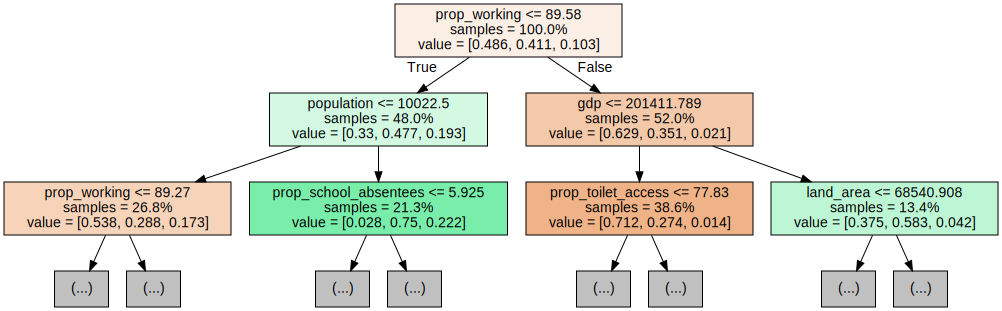

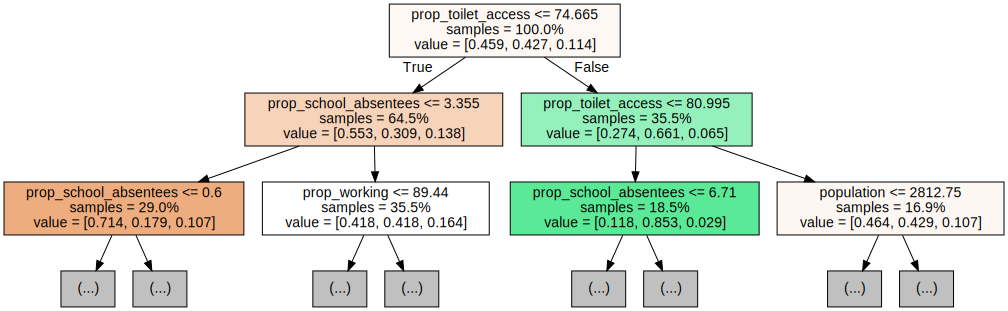

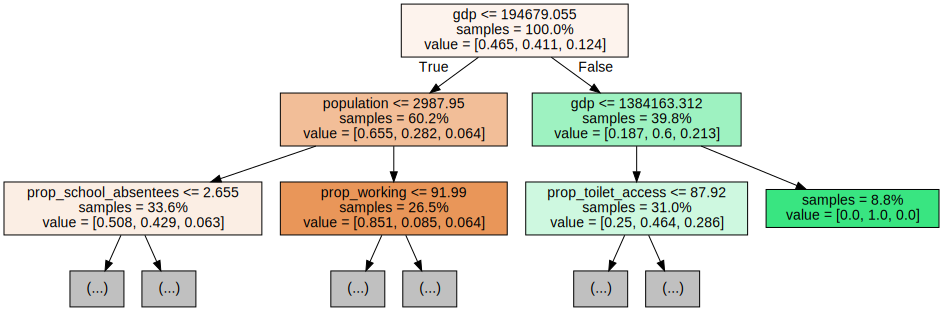

In [ ]:
#first 3 trees visualization 
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5, 
                                 random_state=9)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fab27d43e10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fab27d43650>},
                   random_state=9)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 9, 'n_estimators': 300}


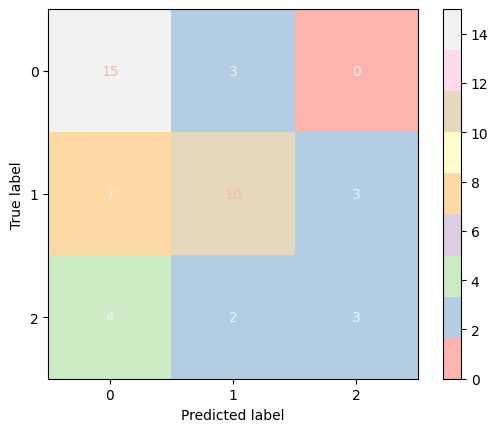

In [ ]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Pastel1");

# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"color": "black"})

# ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Pastel1");
# def color_black(val):
#     return 'color: black'
# styled_confusion_matrix = confusion_matrix.style.applymap(color_black)

# Display the styled confusion matrix


### Random Forest Feature Selection 

In [ ]:
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_

# Print feature importances
features = ["Province", "Year", "energy_generated", "energy_capacity", "maximum_generation"]

features_importance_table = [[features[i], feature_importances[i]] for i in range(len(features))]

# Use tabulate to print the table
table = tabulate(features_importance_table, headers=["Features", "First Row"], tablefmt="grid")

# Print the table
print(table)

+--------------------+-------------+
| Features           |   First Row |
+====================+=============+
| Province           |    0.130025 |
+--------------------+-------------+
| Year               |    0.132575 |
+--------------------+-------------+
| energy_generated   |    0.123782 |
+--------------------+-------------+
| energy_capacity    |    0.139655 |
+--------------------+-------------+
| maximum_generation |    0.180265 |
+--------------------+-------------+


### K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#splitting data, fitting training data to model, 
MinMaxScaler = preprocessing.MinMaxScaler()
X_minmax = MinMaxScaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.3, random_state=9)

In [ ]:
# Create the knn model.
# Look at the five closest neighbors.
knn = KNeighborsClassifier(n_neighbors=5)
# Fit the model on the training data.
knn.fit(X_train, y_train)
# Make point predictions on the test set using the fit model.
y_pred = knn.predict(X_test)
knn_accuracy = knn.score(X_test, y_test)
knn_accuracy

0.5857142857142857

In [ ]:
#clf_accuracy, rf_accuracy, knn_accuracy

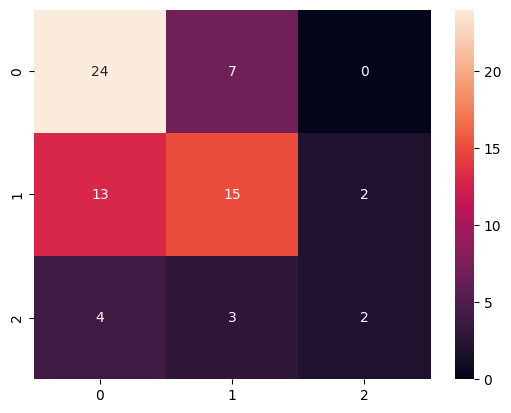

In [ ]:
# Create the confusion matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm_knn = confusion_matrix(y_test, y_pred)
#ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot(cmap="Pastel1");
sn.heatmap(cm_knn, annot=True)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
knn_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])
params = [{'knn__n_neighbors': [3, 5, 7, 9],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [3, 5]}]
gs_knn = GridSearchCV(knn_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

gs_knn.score(X_test, y_test)

# # find best model score
# gs_knn.score(X_test, y_test)
#Output:

feature_names = X.columns
coefficients = gs_knn.coef_

# feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coeff Val')
plt.title('KNN Feature Importance')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

In [ ]:
knn_classifier.fit(X_train, y_train)
feature_importances = rf.feature_importances_

# Print feature importances
features = ["Province", "Year", "energy_generated", "energy_capacity", "maximum_generation"]

features_importance_table = [[features[i], feature_importances[i]] for i in range(len(features))]

# Use tabulate to print the table
table = tabulate(features_importance_table, headers=["Features", "First Row"], tablefmt="grid")

# Print the table
print(table)

NameError: name 'knn_classifier' is not defined

# xgboost 

In [ ]:
#XGBoost Classifier
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
xgb_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=30, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_test = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)


print("Train Accuracy: " + str(accuracy_score(y_train, y_pred_train)) + "\n" + "Test Accuracy: " + str(accuracy_score(y_test, y_pred_test)))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 6.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Train Accuracy: 0.8709677419354839
Test Accuracy: 0.574468085106383


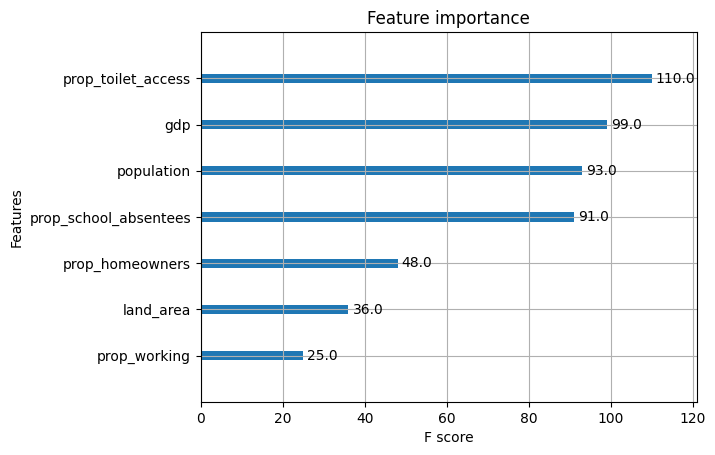

In [ ]:
#Use XGBoost to visualize feature_importance
#Feature Importance of Best Model 
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model)
plt.show()


### cross validation for parameters in xgboost 

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Assuming you have your feature matrix X and target variable y
# X, y = ...

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define a parameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Add other values as needed
    'n_estimators': [40, 50, 100], 'max_depth':[3, 4, 5]}
    # You can include other parameters here
    # Add other parameters as needed


# Create a cross-validation object
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=cv)
grid_result = grid_search.fit(X, y)

# Display the best parameters and corresponding accuracy
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

xgb_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

print("Train Accuracy: " + str(accuracy_score(y_train, y_pred_train)) + "\n" + "Test Accuracy: " + str(accuracy_score(y_test, y_pred_test)))

Best Parameters:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 50}
Best Accuracy:  0.6181313598519889
Train Accuracy: 1.0
Test Accuracy: 0.6595744680851063


In [ ]:
xgb_model = xgb.XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=50, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_test = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

print("Train Accuracy: " + str(accuracy_score(y_train, y_pred_train)) + "\n" + "Test Accuracy: " + str(accuracy_score(y_test, y_pred_test)))

Train Accuracy: 1.0
Test Accuracy: 0.6595744680851063


In [ ]:
pred_2024 = pd.read_csv('/work/pred_2024.csv')

def make_target(x):
    if x > 0.6:
        return 2
    elif x > (1/3):
        return 1
    else:
        return 0



,Province,2024 Energy Generation (GWh),2024 Maximum Generation Capacity (GWh),Ratio Generation:Capacity,[Ridge Regression] Effective generation? (Multiclass),[RF Classifcation] Effective (>0.4 ratio) Generation? (Multiclass),Reg & Classif Match?
0,ACEH,5418.184195,9934.567809,0.545387,1,1,True
1,SUMATERA UTARA,15442.784830,32265.272320,0.478619,1,0,False
2,SUMATERA BARAT,3716.216443,9062.870019,0.410049,1,1,True
3,RIAU,9846.534150,21913.593590,0.449335,1,0,False
4,JAMBI,4652.658456,7224.840226,0.643981,1,0,False
5,SUMATERA SELATAN,6882.536526,13718.806700,0.501686,1,0,False
6,BENGKULU,7468.150508,12694.705030,0.588289,1,1,True
7,LAMPUNG,6376.697912,10038.375150,0.635232,1,1,True
8,KEP. BANGKA BELITUNG,3067.004610,3766.975184,0.814182,1,0,False
9,KEP. RIAU,6428.649232,13130.731290,0.489588,1,1,True


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a2d3571-826e-4759-814d-0768207fd99f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>